# **Objetivo do trabalho: Construir um modelo de Machine Learning que classifica automaticamente críticas de filmes como positivas ou negativas, com base no texto da crítica.**


Passo a passo do código:
1.   Coleta do dataset  – Foi escolhido o dataset "Rotten Tomatoes" do site **Hugging Face**;
2.   Pré-processamento de texto – Limpeza, tokenização, análise e vetorização (TF-IDF por exemplo).
3.   Treinamento dos 4 modelos – Com validação simples(hold-out).
4.   Avaliação com métricas para Validação Simples – Accuracy, Precision, Recall, F1-score, Confusion Matrix
5. Treinamento dos 4 modelos – Com validação cruzada.
6. Avaliação com métricas para Validação Cruzada – Accuracy, Precision, Recall, F1-score, Confusion Matrix
7. Extra - Resultados do Melhor modelo com conjunto de teste

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Gerar o freeze para criar o requirements.txt
%pip freeze > /content/drive/MyDrive/ColabNotebooks/TCC/requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1 -  Coleta do dataset - 10k reviews on **Rotten Tomatoes**


Foi instalado a lib **datasets** para utilizar conseguir carregar direto da internet o dataset dos 10k de filmes do rotten tomatoes.

In [ ]:
# Foi preciso atualizar a lib devido a uma imcompatibilidade interna do fsspec para ser possível interpretar corretamente o padrão de caminho, usado no cache dos datasets.
# A lib datasets usa o fsspec para lidar com arquivos internos.

%pip install -upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which is incompatible.
cudf-cu12 

In [ ]:
#Carrega o load_dataset para acessarmos o dataset da lib datasets
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("rotten_tomatoes")

# Verifica as chaves disponíveis (treino//validação/teste)
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [ ]:
# Ele já vem com split de treino/validação/teste
train_data = dataset["train"]
test_data = dataset["test"]
validation_data = dataset["validation"]

# Converter para dataframe com a lib do Pandas
train_df = train_data.to_pandas()
val_df = validation_data.to_pandas()
test_df = test_data.to_pandas()

# Junta treino + validação para usar no GridSearchCV
trainval_df = pd.concat([train_df, val_df], ignore_index=True)

# Exemplo dataframe de treino
print(train_df.head())

                                                text  label
0  the rock is destined to be the 21st century's ...      1
1  the gorgeously elaborate continuation of " the...      1
2                     effective but too-tepid biopic      1
3  if you sometimes like to go to the movies to h...      1
4  emerges as something rare , an issue movie tha...      1


# 2 - Pré-processamento de texto – Limpeza, tokenização, análise e vetorização (TF-IDF)

2.1 - Limpeza de Texto, Tokenização e Análise Rápida


1.   Deixar tudo em minúsculo
2.   Remover pontuação
3.   Remover **stopwords** (são palavras muito comuns em um idioma que, por si só, não carregam muito significado — especialmente para tarefas como classificação de texto.)
4.   Remover emojis


In [ ]:
%pip install nltk emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
import nltk # Importa a biblioteca NLTK (Natural Language Toolkit) para processamento de linguagem natural
import re # Importa o módulo 're' para usar expressões regulares (ex: remoção de pontuação, números etc.)
import emoji # Importa a biblioteca 'emoji' para detectar e remover emojis dos textos
from nltk.corpus import stopwords # Importa a lista de stopwords do NLTK (palavras comuns como "de", "o", "e"...)

nltk.download('stopwords') # Faz o download das stopwords
stop_words = set(stopwords.words('english'))  # Cria um conjunto com as stopwords da língua inglesa
# Obs: se o texto fosse em português, bastaria trocar 'english' por 'portuguese'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Função de limpeza

def limpar_texto(texto):
    texto = texto.lower()  # Converte todo o texto para letras minúsculas (ex: "Filme Bom" > "filme bom")
    texto = emoji.replace_emoji(texto, replace='')  # Remove qualquer emoji presente no texto
    texto = re.sub(r'[^\w\s]', '', texto)  # Remove pontuação (tudo que não for letra, número ou espaço)
    texto = re.sub(r'\d+', '', texto)  # Remove números do texto
    tokens = texto.split()  # Divide o texto em palavras (tokens) com base nos espaços
    tokens = [t for t in tokens if t not in stop_words]  # Remove as stopwords (palavras comuns e pouco informativas)
    return ' '.join(tokens)  # Junta os tokens de volta em um texto limpo, separado por espaços

In [ ]:
# Exemplo de como é feita a função limpeza

def limpar_texto(texto):
    texto = texto.lower()
    texto = emoji.replace_emoji(texto, replace='')
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    tokens = texto.split()
    tokens = [t for t in tokens if t not in stop_words]
    print(tokens)
    return ' '.join(tokens)

texto = "Eu gostei muito do filme do quarteto fantastico porque ele tem um elenco muito bom, a historia é interessante e tudo mais"
resultado = limpar_texto(texto)
print("Texto bruto:", texto)
print("Texto final limpo:", resultado)

['eu', 'gostei', 'muito', 'filme', 'quarteto', 'fantastico', 'porque', 'ele', 'tem', 'um', 'elenco', 'muito', 'bom', 'historia', 'é', 'interessante', 'e', 'tudo', 'mais']
Texto bruto: Eu gostei muito do filme do quarteto fantastico porque ele tem um elenco muito bom, a historia é interessante e tudo mais
Texto final limpo: eu gostei muito filme quarteto fantastico porque ele tem um elenco muito bom historia é interessante e tudo mais


In [ ]:
# Acessa a coluna "text" do DataFrame que contém as críticas originais dos filmes(em texto bruto)
# Aplica a função "limpar_texto" em cada linha da coluna "text"
# Cria uma nova coluna chamada "clean_text" dentro do DataFrame e armazena ali o resultado da função de limpeza para cada linha

train_df["clean_text"] = train_df["text"].apply(limpar_texto)  # Aplica a função de limpeza nas críticas de treino
val_df["clean_text"] = val_df["text"].apply(limpar_texto)      # Aplica a função de limpeza nas críticas de validação
test_df["clean_text"] = test_df["text"].apply(limpar_texto)    # Aplica a função de limpeza nas críticas de teste

trainval_df["clean_text"] = trainval_df["text"].apply(limpar_texto) # Aplica a função de limpeza nas críticas do treino + validação (para o GridSearchCV)

A saída de streaming foi truncada nas últimas 5000 linhas.
['wake', 'saving', 'private', 'ryan', 'black', 'hawk', 'soldiers', 'likely', 'heartily', 'sick', 'mayhem', 'cages', 'warweary', 'marine']
['messy', 'uncouth', 'incomprehensible', 'vicious', 'absurd']
['really', 'feel', 'like', 'short', 'stretched', 'feature', 'length']
['hampered', 'paralyzed', 'selfindulgent', 'script', 'aims', 'poetry', 'ends', 'sounding', 'like', 'satire']
['cheap', 'vulgar', 'dialogue', 'plot', 'crawls', 'along', 'snails', 'pace']
['appreciate', 'onesided', 'theme', 'lawrences', 'overindulgent', 'tirade', 'knock', 'enjoy', 'big', 'screen', 'postcard', 'selfglorified', 'martin', 'lawrence', 'lovefest', 'willing', 'crazy']
['directed', 'without', 'expected', 'flair', 'imagination', 'hong', 'kong', 'master', 'john', 'woo', 'windtalkers', 'airs', 'every', 'cliche', 'war', 'movie', 'compendium', 'across', 'indulgent', 'twohourandfifteenminute', 'length']
['tasteful', 'rock', 'roll', 'movie', 'could', 'put', 'cof

2.2 - Vetorização: é o processo de transformar o texto em números.

usando o "TF-IDF" (Mede a importância de uma palavra em um documento comparado com todos os documentos. Se uma palavra aparece muito em um texto, mas pouco nos outros, ela é relevante.)

In [ ]:
# Testei o CountVectorizer para tentar melhorar a acurácia no lugar o TF-IDF, mas no geral ficou um pouco pior que os resultados anteriores https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# from sklearn.feature_extraction.text import CountVectorizer

# # Básico (contagem de termos). Sugestões opcionais comentadas:
# # - ngram_range=(1,2) para uni+bi-gramas
# # - min_df=2, max_df=0.9 para filtrar ruído
# # - binary=True para usar presença/ausência em vez de contagem
# vectorizer = CountVectorizer(
#     max_features=5000,
#     min_df=2,
#     max_df=0.9,
#     binary=True,
# )

# # Fit no treino e transform no val/test
# X_train = vectorizer.fit_transform(train_df["clean_text"])
# X_val   = vectorizer.transform(val_df["clean_text"])
# X_test  = vectorizer.transform(test_df["clean_text"])

# # Para os experimentos de validação cruzada (train+val)
# vectorizer_cv = CountVectorizer(
#     max_features=5000,
#     # ngram_range=(1, 2),
#     # min_df=2,
#     # max_df=0.9,
#     # binary=True,
# )
# X_trainval = vectorizer_cv.fit_transform(trainval_df["clean_text"])

# # Labels
# y_train    = train_df["label"]
# y_val      = val_df["label"]
# y_test     = test_df["label"]
# y_trainval = trainval_df["label"]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  # Importa o vetorizador TF-IDF do Scikit-learn

In [ ]:
# Cria o vetorizador TF-IDF para hold-out
# max_features=5000 limita para as 5000 palavras mais relevantes (mais frequentes e informativas)
vectorizer = TfidfVectorizer(max_features=5000)

# Ajusta (fit) o TF-IDF com os dados de treino e transforma (transform) em vetores esparsos
X_train = vectorizer.fit_transform(train_df["clean_text"]) # Treina e transforma os textos de treino
X_val = vectorizer.transform(val_df["clean_text"])         # Apenas transforma os textos de validação
X_test = vectorizer.transform(test_df["clean_text"])       # Apenas transforma os textos de teste


# Define os rótulos (classes) das críticas: 0 = negativa, 1 = positiva
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

# Durante o treinamento (X_train, y_train): O modelo aprende a mapear padrões nos textos (vetores TF-IDF) para os sentimentos reais.
# Durante a validação/teste (X_val, y_val / X_test, y_test): A gente compara a previsão do modelo com o rótulo real, para calcular as métricas (accuracy, precision, etc.).

# Exemplo:
# X_train[0] → vetor que representa: "this movie was amazing"
# y_train[0] → 1 (crítica positiva)
# O modelo vai tentar aprender que certas palavras/padrões levam a uma crítica positiva. E depois, ao receber um novo vetor, ele vai tentar prever se o sentimento é 0 ou 1.

In [ ]:
# Para cross-validation
vectorizer_trainval = TfidfVectorizer(max_features=5000)

X_trainval = vectorizer_trainval.fit_transform(trainval_df["clean_text"])
y_trainval = trainval_df["label"]

X_test_cv = vectorizer_trainval.transform(test_df["clean_text"])
y_test_cv = test_df["label"]

Neste bloco fazemos apenas uma análise rápida depois de os dados já estarem limpos. Nós vemos a distribuição das classes nos 3 conjuntos separados e também juntos.


/tmp/ipython-input-2724976846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


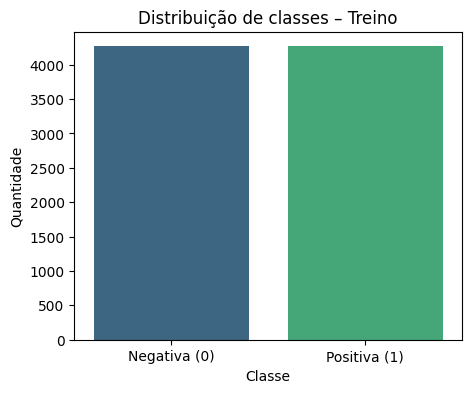

/tmp/ipython-input-2724976846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


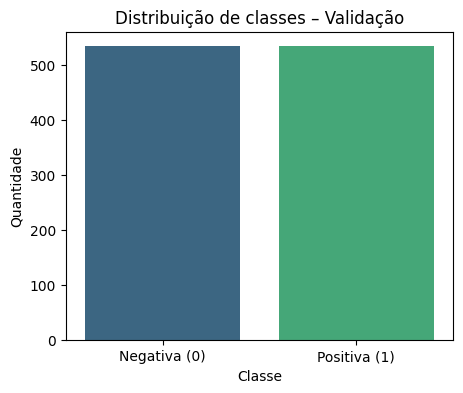

/tmp/ipython-input-2724976846.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


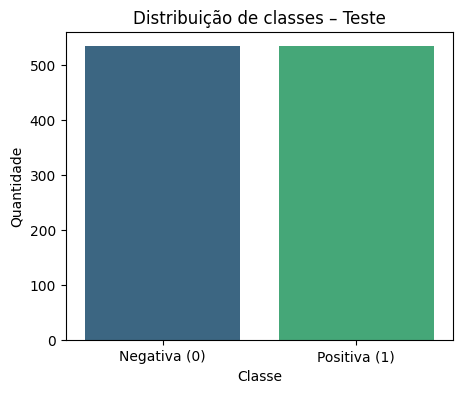

/tmp/ipython-input-2724976846.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df_all, palette="viridis")


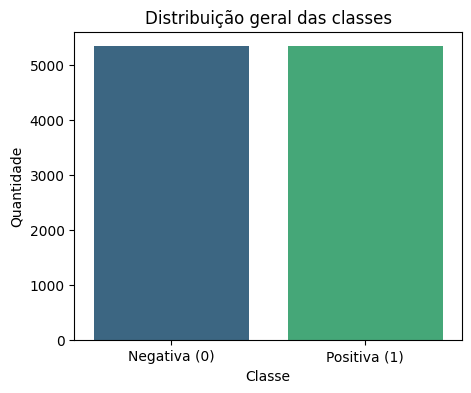

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Função para plotar distribuição de classes de forma separada
def plot_class_distribution(df, title):
    plt.figure(figsize=(5, 4))
    sns.countplot(x="label", data=df, palette="viridis")
    plt.title(f"Distribuição de classes – {title}")
    plt.xlabel("Classe")
    plt.ylabel("Quantidade")
    plt.xticks([0, 1], ["Negativa (0)", "Positiva (1)"])
    plt.show()

# Plota cada conjunto separadamente
plot_class_distribution(train_df, "Treino")
plot_class_distribution(val_df, "Validação")
plot_class_distribution(test_df, "Teste")

# Frequência geral das classes (todos os splits juntos)
df_all = pd.concat([train_df, val_df, test_df], ignore_index=True)
plt.figure(figsize=(5, 4))
sns.countplot(x="label", data=df_all, palette="viridis")
plt.title("Distribuição geral das classes")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.xticks([0, 1], ["Negativa (0)", "Positiva (1)"])
plt.show()

# 3 e 4 - Treinamento dos 4 modelos e Avaliação das métricas – Com validação simples (hold-out)

In [ ]:
# Importações
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    cohen_kappa_score, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

3.1 - Modelo Naive Bayes

/tmp/ipython-input-3576974650.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


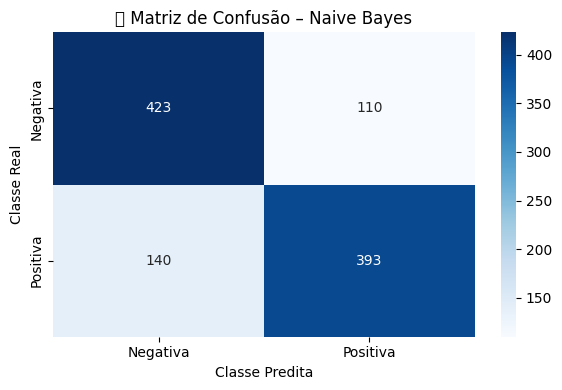

,precision,recall,f1-score,support
Negativa,0.75133,0.79362,0.77190,533.00000
Positiva,0.78131,0.73734,0.75869,533.00000
Acurácia,0.76548,0.76548,0.76548,0.76548
Macro Média,0.76632,0.76548,0.76529,1066.00000


/tmp/ipython-input-3576974650.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


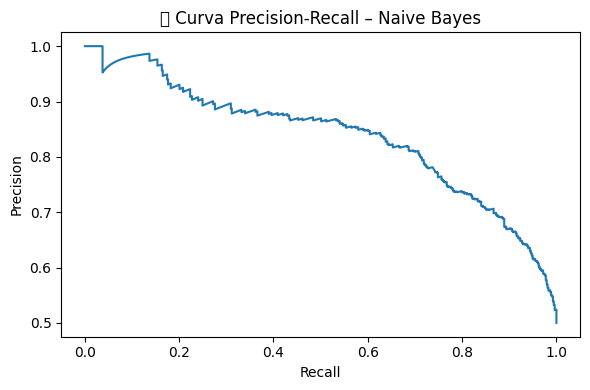

,Métrica,Valor
0,Acurácia,0.76548
1,Kappa de Cohen (κ),0.53096
2,Tempo de execução (s),0.00508


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Cria e treina o modelo
nb_model = MultinomialNB()

# Treinamento + tempo
start_time = time.time()
nb_model.fit(X_train, y_train)
execution_time = time.time() - start_time

# Predições
y_pred = nb_model.predict(X_val)
y_prob = nb_model.predict_proba(X_val)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_val, y_pred)
labels = ["Negativa", "Positiva"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🔍 Matriz de Confusão – Naive Bayes")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()

# Relatório de classificação
report_dict = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
tabela_metrics = report_df.loc[["0", "1", "accuracy", "macro avg"]].copy()
tabela_metrics.index = ["Negativa", "Positiva", "Acurácia", "Macro Média"]
tabela_metrics = tabela_metrics.round(3)
display(tabela_metrics)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Curva Precision-Recall – Naive Bayes")
plt.tight_layout()
plt.show()

# Métricas de resumo (Acurácia, Kappa e Tempo)
acc = accuracy_score(y_val, y_pred)
kappa = cohen_kappa_score(y_val, y_pred) 
resumo_df = pd.DataFrame(
    {"Métrica": ["Acurácia", "Kappa de Cohen (κ)", "Tempo de execução (s)"],
     "Valor":   [round(acc, 3), round(kappa, 3), round(execution_time, 3)]}
)
display(resumo_df)

3.2 - Modelo KNN

/tmp/ipython-input-1755083282.py:32: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


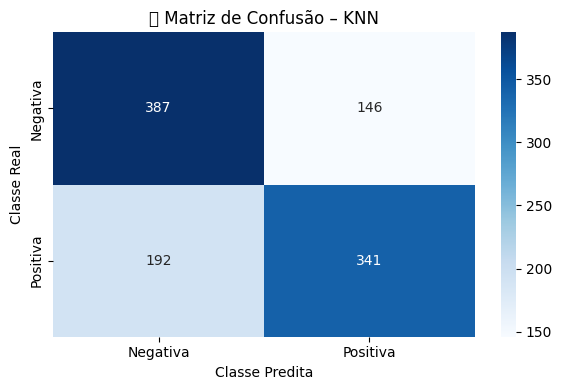

,precision,recall,f1-score,support
Negativa,0.66839,0.72608,0.69604,533.00000
Positiva,0.70021,0.63977,0.66863,533.00000
Acurácia,0.68293,0.68293,0.68293,0.68293
Macro Média,0.68430,0.68293,0.68234,1066.00000


/tmp/ipython-input-1755083282.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


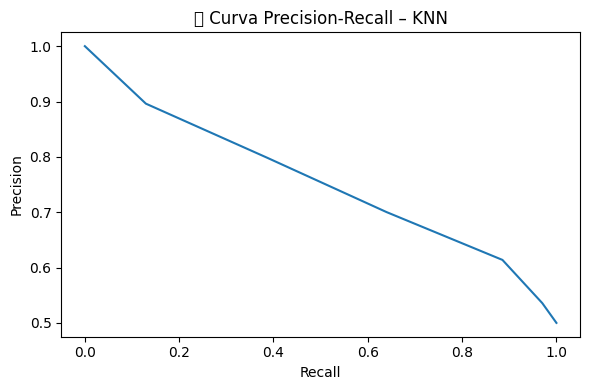

,Métrica,Valor
0,Acurácia,0.68293
1,Kappa de Cohen (κ),0.36585
2,Tempo de execução (s),0.00567


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    cohen_kappa_score, accuracy_score,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# # Cria e treina o modelo (configuração padrão com métrica do cosseno)
knn_model = KNeighborsClassifier(metric='cosine')

# Treinamento + tempo
start_time = time.time()
knn_model.fit(X_train, y_train)
execution_time_knn = time.time() - start_time

# Predições
y_pred_knn = knn_model.predict(X_val)
y_scores = knn_model.predict_proba(X_val)[:, 1]  # usado na curva Precision-Recall

# Matriz de confusão
cm = confusion_matrix(y_val, y_pred_knn)
labels = ["Negativa", "Positiva"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🔍 Matriz de Confusão – KNN")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()

# Relatório de classificação
report_dict = classification_report(y_val, y_pred_knn, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
tabela_metrics = report_df.loc[["0", "1", "accuracy", "macro avg"]].copy()
tabela_metrics.index = ["Negativa", "Positiva", "Acurácia", "Macro Média"]
tabela_metrics = tabela_metrics.round(3)
display(tabela_metrics)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_scores)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Curva Precision-Recall – KNN")
plt.tight_layout()
plt.show()

# Métricas de resumo
acc = accuracy_score(y_val, y_pred_knn)
kappa = cohen_kappa_score(y_val, y_pred_knn)
resumo_df = pd.DataFrame(
    {"Métrica": ["Acurácia", "Kappa de Cohen (κ)", "Tempo de execução (s)"],
     "Valor":   [round(acc, 3), round(kappa, 3), round(execution_time_knn, 3)]}
)
display(resumo_df)

3.3 - Modelo Random Forest

/tmp/ipython-input-3451333938.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


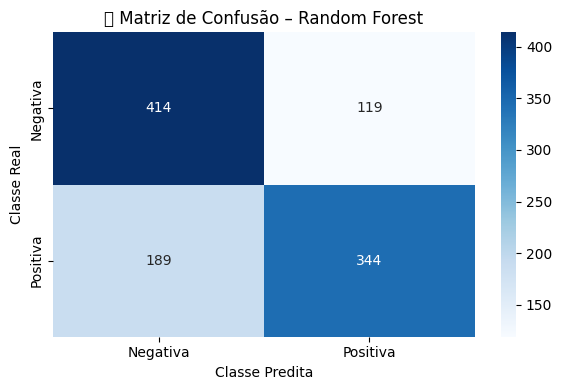

,precision,recall,f1-score,support
Negativa,0.68657,0.77674,0.72887,533.00000
Positiva,0.74298,0.64540,0.69076,533.00000
Acurácia,0.71107,0.71107,0.71107,0.71107
Macro Média,0.71477,0.71107,0.70982,1066.00000


/tmp/ipython-input-3451333938.py:44: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


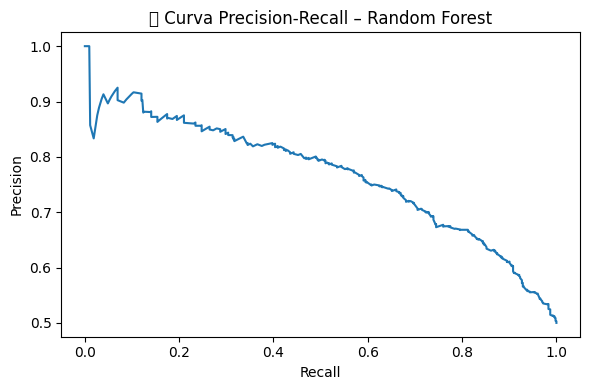

,Métrica,Valor
0,Acurácia,0.71107
1,Kappa de Cohen (κ),0.42214
2,Tempo de execução (s),10.06162


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Cria e treina o modelo
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Treino + tempo
start_time = time.time()
rf_model.fit(X_train, y_train)
execution_time_rf = time.time() - start_time

# Predições
y_pred_rf = rf_model.predict(X_val)
y_prob = rf_model.predict_proba(X_val)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_val, y_pred_rf)
labels = ["Negativa", "Positiva"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🔍 Matriz de Confusão – Random Forest")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()

# Relatório de classificação
report_dict = classification_report(y_val, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
tabela_metrics = report_df.loc[["0", "1", "accuracy", "macro avg"]].copy()
tabela_metrics.index = ["Negativa", "Positiva", "Acurácia", "Macro Média"]
tabela_metrics = tabela_metrics.round(3)
display(tabela_metrics)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Curva Precision-Recall – Random Forest")
plt.tight_layout()
plt.show()

# Métricas de resumo (Acurácia, Kappa e Tempo)
acc = accuracy_score(y_val, y_pred_rf)
kappa = cohen_kappa_score(y_val, y_pred_rf)
resumo_df = pd.DataFrame(
    {"Métrica": ["Acurácia", "Kappa de Cohen (κ)", "Tempo de execução (s)"],
     "Valor":   [round(acc, 3), round(kappa, 3), round(execution_time_rf, 3)]}
)
display(resumo_df)

3.4 - Modelo XGBoost

/tmp/ipython-input-4165109873.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


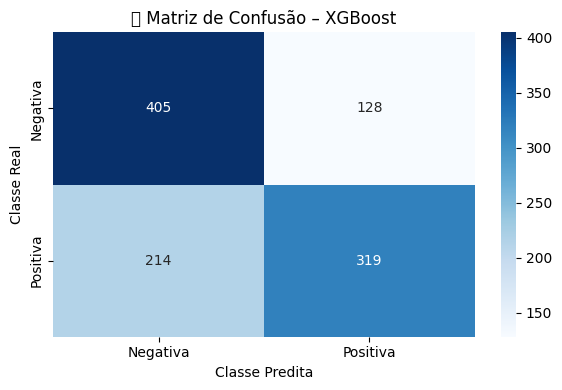

,precision,recall,f1-score,support
Negativa,0.65428,0.75985,0.70312,533.00000
Positiva,0.71365,0.59850,0.65102,533.00000
Acurácia,0.67917,0.67917,0.67917,0.67917
Macro Média,0.68396,0.67917,0.67707,1066.00000


/tmp/ipython-input-4165109873.py:47: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


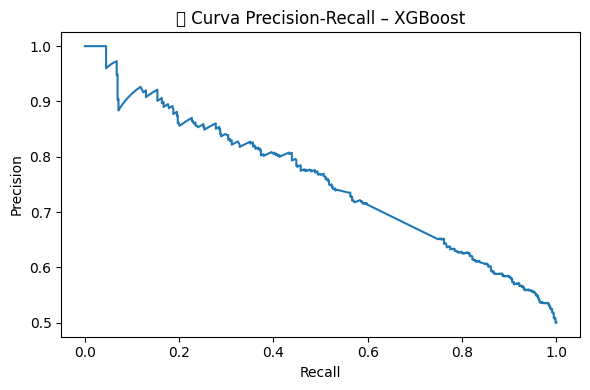

,Métrica,Valor
0,Acurácia,0.67917
1,Kappa de Cohen (κ),0.35835
2,Tempo de execução (s),5.49756


In [ ]:
# Instalar o XGBoost
%pip install xgboost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

# Treino + tempo
start_time = time.time()
xgb_model.fit(X_train, y_train)
execution_time_xgb = time.time() - start_time

# Predições
y_pred_xgb = xgb_model.predict(X_val)
y_prob = xgb_model.predict_proba(X_val)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_val, y_pred_xgb)
labels = ["Negativa", "Positiva"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("🔍 Matriz de Confusão – XGBoost")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()

# Relatório de classificação
report_dict = classification_report(y_val, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
tabela_metrics = report_df.loc[["0", "1", "accuracy", "macro avg"]].copy()
tabela_metrics.index = ["Negativa", "Positiva", "Acurácia", "Macro Média"]
tabela_metrics = tabela_metrics.round(3)
display(tabela_metrics)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📈 Curva Precision-Recall – XGBoost")
plt.tight_layout()
plt.show()

# Métricas de resumo (Acurácia, Kappa e Tempo)
acc = accuracy_score(y_val, y_pred_xgb)
kappa = cohen_kappa_score(y_val, y_pred_xgb)
resumo_df = pd.DataFrame(
    {"Métrica": ["Acurácia", "Kappa de Cohen (κ)", "Tempo de execução (s)"],
     "Valor":   [round(acc, 3), round(kappa, 3), round(execution_time_xgb, 3)]}
)
display(resumo_df)

**Tabela Comparativa**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score
import pandas as pd

# Tabela comparativa com base no conjunto de validação (X_val)
holdout_results = {
    "Modelo": ["Naive Bayes", "KNN", "Random Forest", "XGBoost"],
    "Acurácia": [
        accuracy_score(y_val, y_pred),        # NB
        accuracy_score(y_val, y_pred_knn),    # KNN
        accuracy_score(y_val, y_pred_rf),     # RF
        accuracy_score(y_val, y_pred_xgb),    # XGB
    ],
    "Precision": [
        precision_score(y_val, y_pred),
        precision_score(y_val, y_pred_knn),
        precision_score(y_val, y_pred_rf),
        precision_score(y_val, y_pred_xgb),
    ],
    "Recall": [
        recall_score(y_val, y_pred),
        recall_score(y_val, y_pred_knn),
        recall_score(y_val, y_pred_rf),
        recall_score(y_val, y_pred_xgb),
    ],
    "F1-Score": [
        f1_score(y_val, y_pred),
        f1_score(y_val, y_pred_knn),
        f1_score(y_val, y_pred_rf),
        f1_score(y_val, y_pred_xgb),
    ],
    "Kappa (κ)": [
        cohen_kappa_score(y_val, y_pred),
        cohen_kappa_score(y_val, y_pred_knn),
        cohen_kappa_score(y_val, y_pred_rf),
        cohen_kappa_score(y_val, y_pred_xgb),
    ],
    "Tempo (s)": [
        execution_time,       # NB
        execution_time_knn,   # KNN
        execution_time_rf,    # RF
        execution_time_xgb,   # XGB
    ],
}

# Converte em DataFrame
holdout_df = pd.DataFrame(holdout_results)

# Arredonda as métricas
cols_to_round = ["Acurácia", "Precision", "Recall", "F1-Score", "Kappa (κ)", "Tempo (s)"]
holdout_df[cols_to_round] = holdout_df[cols_to_round].round(3)

# Exibe a tabela de comparação
print("\n📋 Tabela comparativa - Hold-Out (validação):")
display(holdout_df)


📋 Tabela comparativa – Hold-Out (validação):


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (κ),Tempo (s)
0,Naive Bayes,0.76548,0.78131,0.73734,0.75869,0.53096,0.00508
1,KNN,0.68293,0.70021,0.63977,0.66863,0.36585,0.00567
2,Random Forest,0.71107,0.74298,0.64540,0.69076,0.42214,10.06162
3,XGBoost,0.67917,0.71365,0.59850,0.65102,0.35835,5.49756


# 5 e 6- Treinamento dos 4 modelos e Avaliação das métricas – Com validação cruzada

In [ ]:
# Importa do np para calcular média e desvio padrão e feature para validação cruzada
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import numpy as np
import time
import pandas as pd

3.1 - Modelo Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import time
import pandas as pd

# Hiperparâmetros a serem testados no Grid Search
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

rows = []

# 10 repetições com dobras embaralhadas
for run in range(10):
    cv = KFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(
        MultinomialNB(),
        param_grid=param_grid_nb,
        cv=cv,
        scoring='accuracy',
        refit=False,                 
        n_jobs=-1,
        return_train_score=False
    )

    t0 = time.time()
    grid.fit(X_trainval, y_trainval)
    t_search = time.time() - t0     # tempo da busca (todas as combinações × dobras)

    best_idx    = grid.best_index_
    best_params = grid.best_params_

    # CV: média e desvio da melhor combinação desta execução
    cv_acc_mean = float(grid.cv_results_['mean_test_score'][best_idx])
    cv_acc_std  = float(grid.cv_results_['std_test_score'][best_idx])

    rows.append({
        'RUN': run,
        'BEST_PARAMS': best_params,
        'BEST_PARAMS_TUPLE': tuple(sorted(best_params.items())),
        'CV_ACC_MEAN': round(cv_acc_mean, 3),
        'CV_ACC_STD':  round(cv_acc_std, 3),
        'TIME_CV_S':   round(t_search, 3)
    })

# --- Tabela por execução: parâmetros + acurácia (média ± desvio) ---
exec_nb = pd.DataFrame(rows)

exec_show = exec_nb.rename(columns={
    'RUN': 'Execução',
    'BEST_PARAMS': 'Parâmetros',
    'CV_ACC_MEAN': 'Acurácia Média',
    'CV_ACC_STD':  'Desvio Padrão',
    'TIME_CV_S':   'Tempo de Execução (s)'
})[['Execução','Parâmetros','Acurácia Média','Desvio Padrão','Tempo de Execução (s)']]

print(" CV por execução (5 dobras, média ± desvio) e melhores parâmetros — Naive Bayes:")
display(exec_show)

# --- Melhor caso absoluto na CV (maior Acurácia Média entre as 10 execuções) ---
i = exec_nb['CV_ACC_MEAN'].idxmax()
best_params_nb = exec_nb.loc[i, 'BEST_PARAMS']
best_cv_mean   = float(exec_nb.loc[i, 'CV_ACC_MEAN'])
best_cv_std    = float(exec_nb.loc[i, 'CV_ACC_STD'])
best_run       = int(exec_nb.loc[i, 'RUN'])

best_params_df = pd.DataFrame([{
    'Melhores Parâmetros (absoluto)': best_params_nb,
    'Execução': best_run,
    'Acurácia Média (CV)': round(best_cv_mean, 3),
    'Desvio Padrão (CV)': round(best_cv_std, 3)
}])

print("\n Melhor caso absoluto na CV — Naive Bayes:")
display(best_params_df)

# --- Modelo final: treina em train+val com melhores parâmetros e avalia no teste ---
final_model = MultinomialNB(**best_params_nb)

t0 = time.time()
final_model.fit(X_trainval, y_trainval)
fit_time = time.time() - t0

y_pred = final_model.predict(X_test_cv)

final_metrics_nb = pd.DataFrame([{
    'Modelo':   'Naive Bayes',
    'Acurácia':  round(accuracy_score(y_test_cv, y_pred), 3),
    'Precision': round(precision_score(y_test_cv, y_pred), 3),
    'Recall':    round(recall_score(y_test_cv, y_pred), 3),
    'F1-Score':  round(f1_score(y_test_cv, y_pred), 3),
    'Kappa (k)': round(cohen_kappa_score(y_test_cv, y_pred), 3),
    'Tempo (s)': round(fit_time, 3)
}])

print("\n Desempenho no teste (modelo final com melhores parâmetros) — Naive Bayes:")
display(final_metrics_nb)

 CV por execução (5 dobras, média ± desvio) e melhores parâmetros — Naive Bayes:


,Execução,Parâmetros,Acurácia Média,Desvio Padrão,Tempo de Execução (s)
0,0,"{'alpha': 1.0, 'fit_prior': False}",0.75959,0.00503,2.6312
1,1,"{'alpha': 1.0, 'fit_prior': True}",0.76167,0.00501,0.1968
2,2,"{'alpha': 1.0, 'fit_prior': False}",0.76105,0.00835,0.2038
3,3,"{'alpha': 1.0, 'fit_prior': False}",0.75761,0.00383,0.1914
4,4,"{'alpha': 1.0, 'fit_prior': False}",0.75980,0.00933,0.2048
5,5,"{'alpha': 1.0, 'fit_prior': False}",0.76073,0.00450,0.1962
6,6,"{'alpha': 1.0, 'fit_prior': False}",0.76167,0.01161,0.1962
7,7,"{'alpha': 1.0, 'fit_prior': False}",0.76011,0.00604,0.2066
8,8,"{'alpha': 1.0, 'fit_prior': False}",0.76240,0.00703,0.1910
9,9,"{'alpha': 1.0, 'fit_prior': False}",0.75834,0.00542,0.2053



 Melhor caso absoluto na CV — Naive Bayes:


,Melhores Parâmetros (absoluto),Execução,Acurácia Média (CV),Desvio Padrão (CV)
0,"{'alpha': 1.0, 'fit_prior': False}",8,0.7624,0.00703



 Desempenho no teste (modelo final com melhores parâmetros) — Naive Bayes:


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,Naive Bayes,0.77298,0.77927,0.76173,0.7704,0.54597,0.0052


3.2 - Modelo KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Hiperparâmetros a serem testados no Grid Search
param_grid_knn = {
    'n_neighbors': [3, 5, 11],
    'metric': ['cosine', 'euclidean'],
    # 'algorithm': ['brute'],        
    # 'weights': ['uniform', 'distance'],
}

rows = []

# 10 repetições com dobras embaralhadas
for run in range(10):
    cv = KFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(
        KNeighborsClassifier(n_jobs=-1),
        param_grid=param_grid_knn,
        cv=cv,
        scoring='accuracy',
        refit=False,
        n_jobs=-1,
        return_train_score=False
    )

    t0 = time.time()
    grid.fit(X_trainval, y_trainval)
    t_search = time.time() - t0

    best_idx    = grid.best_index_
    best_params = grid.best_params_

    # CV: média e desvio nas 5 dobras da melhor combinação desta execução
    cv_acc_mean = float(grid.cv_results_['mean_test_score'][best_idx])
    cv_acc_std  = float(grid.cv_results_['std_test_score'][best_idx])

    rows.append({
        'RUN': run,
        'BEST_PARAMS': best_params,
        'BEST_PARAMS_TUPLE': tuple(sorted(best_params.items())),
        'CV_ACC_MEAN': round(cv_acc_mean, 3),
        'CV_ACC_STD':  round(cv_acc_std, 3),
        'TIME_CV_S':   round(t_search, 3)
    })

# --- Tabela por execução: parâmetros + acurácia (média ± desvio) ---
exec_knn = pd.DataFrame(rows)

exec_show = exec_knn.rename(columns={
    'RUN': 'Execução',
    'BEST_PARAMS': 'Parâmetros',
    'CV_ACC_MEAN': 'Acurácia Média',
    'CV_ACC_STD':  'Desvio Padrão',
    'TIME_CV_S':   'Tempo de Execução (s)'
})[['Execução','Parâmetros','Acurácia Média','Desvio Padrão','Tempo de Execução (s)']]

print(" CV por execução (5 dobras, média ± desvio) e melhores parâmetros — KNN:")
display(exec_show)

# --- Melhor caso absoluto na CV (entre as 10 execuções) ---
i = exec_knn['CV_ACC_MEAN'].idxmax()
best_params_knn = exec_knn.loc[i, 'BEST_PARAMS']
best_cv_mean     = float(exec_knn.loc[i, 'CV_ACC_MEAN'])
best_cv_std      = float(exec_knn.loc[i, 'CV_ACC_STD'])
best_run         = int(exec_knn.loc[i, 'RUN'])

best_params_df = pd.DataFrame([{
    'Melhores Parâmetros (absoluto)': best_params_knn,
    'Execução': best_run,
    'Acurácia Média (CV)': round(best_cv_mean, 3),
    'Desvio Padrão (CV)': round(best_cv_std, 3)
}])

print("\n Melhor caso absoluto na CV — KNN:")
display(best_params_df)

# --- Modelo final: treina em train+val com os melhores parâmetros e avalia no teste ---
final_model = KNeighborsClassifier(n_jobs=-1, **best_params_knn)

t0 = time.time()
final_model.fit(X_trainval, y_trainval)   # KNN "treina" armazenando os vetores
fit_time = time.time() - t0

y_pred = final_model.predict(X_test_cv)

final_metrics_knn = pd.DataFrame([{
    'Modelo':   'KNN',
    'Acurácia':  round(accuracy_score(y_test_cv, y_pred), 3),
    'Precision': round(precision_score(y_test_cv, y_pred), 3),
    'Recall':    round(recall_score(y_test_cv, y_pred), 3),
    'F1-Score':  round(f1_score(y_test_cv, y_pred), 3),
    'Kappa (k)': round(cohen_kappa_score(y_test_cv, y_pred), 3),
    'Tempo (s)': round(fit_time, 3)
}])

print("\n Desempenho no teste (modelo final com melhores parâmetros) — KNN:")
display(final_metrics_knn)

 CV por execução (5 dobras, média ± desvio) e melhores parâmetros — KNN:


,Execução,Parâmetros,Acurácia Média,Desvio Padrão,Tempo de Execução (s)
0,0,"{'metric': 'cosine', 'n_neighbors': 11}",0.71071,0.01263,16.2442
1,1,"{'metric': 'cosine', 'n_neighbors': 11}",0.70957,0.01218,17.3699
2,2,"{'metric': 'cosine', 'n_neighbors': 11}",0.71040,0.00899,19.1629
3,3,"{'metric': 'cosine', 'n_neighbors': 11}",0.70915,0.00578,18.3046
4,4,"{'metric': 'cosine', 'n_neighbors': 11}",0.71363,0.00591,18.0768
5,5,"{'metric': 'cosine', 'n_neighbors': 11}",0.70707,0.00378,15.0162
6,6,"{'metric': 'cosine', 'n_neighbors': 11}",0.71103,0.00764,13.7823
7,7,"{'metric': 'cosine', 'n_neighbors': 11}",0.70821,0.00473,13.8613
8,8,"{'metric': 'cosine', 'n_neighbors': 11}",0.70946,0.01157,14.4531
9,9,"{'metric': 'cosine', 'n_neighbors': 11}",0.71269,0.01531,14.0535



 Melhor caso absoluto na CV — KNN:


,Melhores Parâmetros (absoluto),Execução,Acurácia Média (CV),Desvio Padrão (CV)
0,"{'metric': 'cosine', 'n_neighbors': 11}",4,0.71363,0.00591



 Desempenho no teste (modelo final com melhores parâmetros) — KNN:


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,KNN,0.69887,0.71285,0.66604,0.68865,0.39775,0.0037


3.3 - Modelo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Hiperparâmetros a serem testados no GridSearch
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

rows = []

# 10 repetições com dobras embaralhadas
for run in range(10):
    cv = KFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(
        RandomForestClassifier(random_state=run, n_jobs=-1),
        param_grid=param_grid_rf,
        cv=cv,
        scoring='accuracy',
        refit=False,
        n_jobs=-1,
        return_train_score=False
    )

    t0 = time.time()
    grid.fit(X_trainval, y_trainval)
    t_search = time.time() - t0

    best_idx    = grid.best_index_
    best_params = grid.best_params_

    # CV: média e desvio da melhor combinação desta execução
    cv_acc_mean = float(grid.cv_results_['mean_test_score'][best_idx])
    cv_acc_std  = float(grid.cv_results_['std_test_score'][best_idx])

    rows.append({
        'RUN': run,
        'BEST_PARAMS': best_params,
        'BEST_PARAMS_TUPLE': tuple(sorted(best_params.items())),
        'CV_ACC_MEAN': round(cv_acc_mean, 3),
        'CV_ACC_STD':  round(cv_acc_std, 3),
        'TIME_CV_S':   round(t_search, 3)
    })

# --- Tabela por execução: parâmetros + acurácia (média ± desvio) ---
exec_rf = pd.DataFrame(rows)

exec_show = exec_rf.rename(columns={
    'RUN': 'Execução',
    'BEST_PARAMS': 'Parâmetros',
    'CV_ACC_MEAN': 'Acurácia Média',
    'CV_ACC_STD':  'Desvio Padrão',
    'TIME_CV_S':   'Tempo de Execução (s)'
})[['Execução','Parâmetros','Acurácia Média','Desvio Padrão','Tempo de Execução (s)']]

print(" CV por execução (5 dobras, média ± desvio) e melhores parâmetros — RF:")
display(exec_show)

# --- Melhor caso absoluto na CV (maior Acurácia Média entre as 10 execuções) ---
i = exec_rf['CV_ACC_MEAN'].idxmax()
best_params_rf = exec_rf.loc[i, 'BEST_PARAMS']
best_cv_mean   = float(exec_rf.loc[i, 'CV_ACC_MEAN'])
best_cv_std    = float(exec_rf.loc[i, 'CV_ACC_STD'])
best_run       = int(exec_rf.loc[i, 'RUN'])

best_params_df = pd.DataFrame([{
    'Melhores Parâmetros (absoluto)': best_params_rf,
    'Execução': best_run,
    'Acurácia Média (CV)': round(best_cv_mean, 3),
    'Desvio Padrão (CV)': round(best_cv_std, 3)
}])

print("\n Melhor caso absoluto na CV — RF:")
display(best_params_df)

# --- Modelo final: treina em train+val com melhores parâmetros e avalia no teste ---
final_model = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)

t0 = time.time()
final_model.fit(X_trainval, y_trainval)
fit_time = time.time() - t0

y_pred = final_model.predict(X_test_cv)

final_metrics_rf = pd.DataFrame([{
    'Modelo':   'Random Forest',
    'Acurácia':  round(accuracy_score(y_test_cv, y_pred), 3),
    'Precision': round(precision_score(y_test_cv, y_pred), 3),
    'Recall':    round(recall_score(y_test_cv, y_pred), 3),
    'F1-Score':  round(f1_score(y_test_cv, y_pred), 3),
    'Kappa (k)': round(cohen_kappa_score(y_test_cv, y_pred), 3),
    'Tempo (s)': round(fit_time, 4)
}])

print("\n Desempenho no teste (modelo final com melhores parâmetros) — RF:")
display(final_metrics_rf)


 CV por execução (5 dobras, média ± desvio) e melhores parâmetros — RF:


,Execução,Parâmetros,Acurácia Média,Desvio Padrão,Tempo de Execução (s)
0,0,"{'max_depth': None, 'n_estimators': 200}",0.69873,0.00443,164.1418
1,1,"{'max_depth': None, 'n_estimators': 100}",0.70186,0.01157,161.0708
2,2,"{'max_depth': None, 'n_estimators': 200}",0.70342,0.00639,160.0496
3,3,"{'max_depth': None, 'n_estimators': 200}",0.69665,0.01082,158.4363
4,4,"{'max_depth': None, 'n_estimators': 200}",0.69508,0.01265,159.2272
5,5,"{'max_depth': None, 'n_estimators': 200}",0.69894,0.00730,158.8275
6,6,"{'max_depth': None, 'n_estimators': 200}",0.70258,0.00768,159.5905
7,7,"{'max_depth': None, 'n_estimators': 200}",0.70123,0.01433,158.4695
8,8,"{'max_depth': None, 'n_estimators': 200}",0.69977,0.01344,161.3512
9,9,"{'max_depth': None, 'n_estimators': 200}",0.70331,0.00643,158.6993



 Melhor caso absoluto na CV — RF:


,Melhores Parâmetros (absoluto),Execução,Acurácia Média (CV),Desvio Padrão (CV)
0,"{'max_depth': None, 'n_estimators': 200}",2,0.70342,0.00639



 Desempenho no teste (modelo final com melhores parâmetros) — RF:


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,Random Forest,0.72702,0.74795,0.6848,0.71499,0.45403,23.1562


3.4 - Modelo XGBoost

In [ ]:
!pip install xgboost

from xgboost import XGBClassifier

# Hiperparâmetros a serem testados no GridSearch
param_grid_xgb = {
    'n_estimators':   [100, 200],
    'learning_rate':  [0.1, 0.3],
}

rows = []

# 10 repetições com dobras embaralhadas
for run in range(10):
    cv = KFold(n_splits=5, shuffle=True, random_state=run)

    grid = GridSearchCV(
        XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',   # evita warnings e é estável
            tree_method='hist',      # mais rápido e estável com TF-IDF esparso
            random_state=run,
            n_jobs=-1,
            use_label_encoder=False  
        ),
        param_grid=param_grid_xgb,
        cv=cv,
        scoring='accuracy',
        refit=False,
        n_jobs=-1,
        return_train_score=False
    )

    t0 = time.time()
    grid.fit(X_trainval, y_trainval)
    t_search = time.time() - t0

    best_idx    = grid.best_index_
    best_params = grid.best_params_

    # CV: média e desvio da melhor combinação desta execução
    cv_acc_mean = float(grid.cv_results_['mean_test_score'][best_idx])
    cv_acc_std  = float(grid.cv_results_['std_test_score'][best_idx])

    rows.append({
        'RUN': run,
        'BEST_PARAMS': best_params,
        'BEST_PARAMS_TUPLE': tuple(sorted(best_params.items())),
        'CV_ACC_MEAN': round(cv_acc_mean, 3),
        'CV_ACC_STD':  round(cv_acc_std, 3),
        'TIME_CV_S':   round(t_search, 3)
    })

# --- Tabela por execução: parâmetros + acurácia (média ± desvio) ---
exec_df = pd.DataFrame(rows)
exec_xgb = exec_df.copy()

exec_show = exec_xgb.rename(columns={
    'RUN': 'Execução',
    'BEST_PARAMS': 'Parâmetros',
    'CV_ACC_MEAN': 'Acurácia Média',
    'CV_ACC_STD':  'Desvio Padrão',
    'TIME_CV_S':   'Tempo de Execução (s)'
})[['Execução','Parâmetros','Acurácia Média','Desvio Padrão','Tempo de Execução (s)']]

print(" CV por execução (5 dobras, média ± desvio) e melhores parâmetros — XGBoost:")
display(exec_show)

# --- Melhor caso absoluto na CV (maior Acurácia Média entre as 10 execuções) ---
i = exec_xgb['CV_ACC_MEAN'].idxmax()
best_params_xgb = exec_xgb.loc[i, 'BEST_PARAMS']
best_run_xgb    = int(exec_xgb.loc[i, 'RUN'])
best_cv_mean    = float(exec_xgb.loc[i, 'CV_ACC_MEAN'])
best_cv_std     = float(exec_xgb.loc[i, 'CV_ACC_STD'])

best_params_df = pd.DataFrame([{
    'Melhores Parâmetros (absoluto)': best_params_xgb,
    'Execução': best_run_xgb,
    'Acurácia Média (CV)': round(best_cv_mean, 3),
    'Desvio Padrão (CV)': round(best_cv_std, 3)
}])

print("\n Melhor caso absoluto na CV — XGBoost:")
display(best_params_df)

# --- Modelo final: treina em train+val com melhores parâmetros e avalia no teste ---
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    **best_params_xgb
)

t0 = time.time()
final_model.fit(X_trainval, y_trainval)
fit_time = time.time() - t0

y_pred = final_model.predict(X_test_cv)

final_metrics_xgb = pd.DataFrame([{
    'Modelo':   'XGBoost',
    'Acurácia':  round(accuracy_score(y_test_cv, y_pred), 3),
    'Precision': round(precision_score(y_test_cv, y_pred), 3),
    'Recall':    round(recall_score(y_test_cv, y_pred), 3),
    'F1-Score':  round(f1_score(y_test_cv, y_pred), 3),
    'Kappa (k)': round(cohen_kappa_score(y_test_cv, y_pred), 3),
    'Tempo (s)': round(fit_time, 4)
}])

print("\n Desempenho no teste (modelo final com melhores parâmetros) — XGBoost:")
display(final_metrics_xgb)

 CV por execução (5 dobras, média ± desvio) e melhores parâmetros — XGBoost:


,Execução,Parâmetros,Acurácia Média,Desvio Padrão,Tempo de Execução (s)
0,0,"{'learning_rate': 0.3, 'n_estimators': 200}",0.70217,0.00823,80.6213
1,1,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69487,0.00878,80.5717
2,2,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69727,0.01386,80.3257
3,3,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69717,0.00563,80.3160
4,4,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69664,0.01191,80.2364
5,5,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69664,0.00373,80.2728
6,6,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69623,0.00863,80.4425
7,7,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69195,0.01217,80.4016
8,8,"{'learning_rate': 0.3, 'n_estimators': 200}",0.69612,0.00948,79.7417
9,9,"{'learning_rate': 0.3, 'n_estimators': 200}",0.70040,0.00967,79.0293



 Melhor caso absoluto na CV — XGBoost:


,Melhores Parâmetros (absoluto),Execução,Acurácia Média (CV),Desvio Padrão (CV)
0,"{'learning_rate': 0.3, 'n_estimators': 200}",0,0.70217,0.00823



 Desempenho no teste (modelo final com melhores parâmetros) — XGBoost:


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,XGBoost,0.71201,0.73251,0.66792,0.69872,0.42402,7.0752


**Tabela Comparativa**

In [ ]:
import pandas as pd
import numpy as np

model_dfs = [
    ("Naive Bayes", final_metrics_nb),
    ("KNN",         final_metrics_knn),
    ("Random Forest", final_metrics_rf),
    ("XGBoost",       final_metrics_xgb),
]

# Mapeamento para lidar com variações de nome de coluna
COLS = {
    "acc": ["Acurácia"],
    "prec": ["Precision"],
    "rec": ["Recall"],
    "f1": ["F1-Score"],
    "kappa": ["Kappa (k)"],
    "time": ["Tempo (s)"]
}

def pick_col(df, options):
    for c in options:
        if c in df.columns:
            return c
    raise KeyError(f"Não encontrei nenhuma destas colunas no DataFrame: {options}")

linhas = []
for nome, df in model_dfs:
    acc_col   = pick_col(df, COLS["acc"])
    prec_col  = pick_col(df, COLS["prec"])
    rec_col   = pick_col(df, COLS["rec"])
    f1_col    = pick_col(df, COLS["f1"])
    kappa_col = pick_col(df, COLS["kappa"])
    time_col  = pick_col(df, COLS["time"])

    linhas.append({
        "Modelo": nome,
        "Acurácia":  float(np.mean(df[acc_col])),
        "Precision": float(np.mean(df[prec_col])),
        "Recall":    float(np.mean(df[rec_col])),
        "F1-Score":  float(np.mean(df[f1_col])),
        "Kappa (k)": float(np.mean(df[kappa_col])),
        "Tempo (s)": float(np.mean(df[time_col])),
    })

tabela_final = pd.DataFrame(linhas)

# Ordena por Acurácia (desc) e arredonda
tabela_final = (tabela_final
                .sort_values("Acurácia", ascending=False)
                .reset_index(drop=True)
                .round({"Acurácia":3, "Precision":3, "Recall":3, "F1-Score":3, "Kappa (k)":3, "Tempo (s)":3}))

print("\n📋 Tabela comparativa – desempenho no TESTE:")
display(tabela_final)



📋 Tabela comparativa – desempenho no TESTE:


,Modelo,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,Naive Bayes,0.77298,0.77927,0.76173,0.77040,0.54597,0.0052
1,Random Forest,0.72702,0.74795,0.68480,0.71499,0.45403,23.1562
2,XGBoost,0.71201,0.73251,0.66792,0.69872,0.42402,7.0752
3,KNN,0.69887,0.71285,0.66604,0.68865,0.39775,0.0037


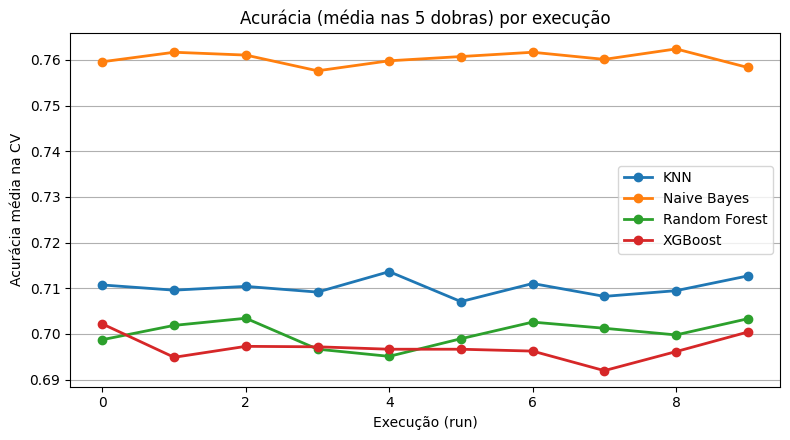

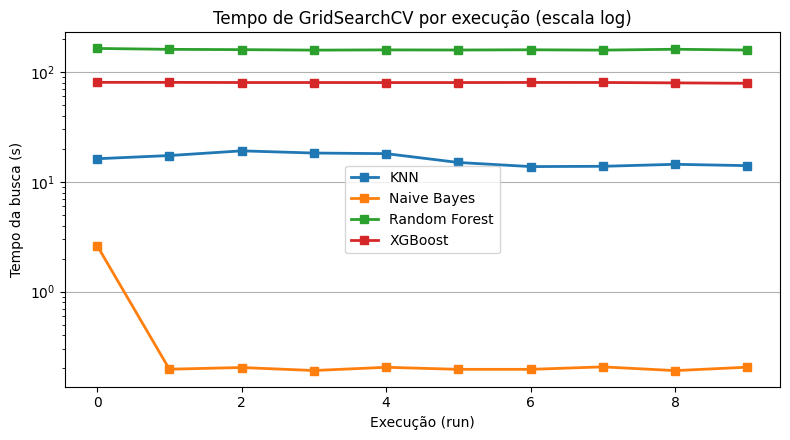

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Helper para padronizar nomes de colunas vindas de cada bloco ----
def unify_exec(df, model_name):
    # aceita tanto nomes em PT quanto em EN usados nos seus blocos
    col_map = {
        'RUN': 'run', 'Execução': 'run',
        'CV_ACC_MEAN': 'cv_acc', 'Acurácia Média': 'cv_acc',
        'TIME_CV_S': 'time', 'Tempo de Execução (s)': 'time'
    }
    g = df.rename(columns=col_map)[['run', 'cv_acc', 'time']].copy()
    g['Modelo'] = model_name
    # garante ordenação por execução
    g = g.sort_values('run')
    return g

# ---- Junte aqui os quatro DataFrames de execuções ----
# (troque pelos nomes que você salvou aí)
all_exec = pd.concat([
    unify_exec(exec_nb,  "Naive Bayes"),
    unify_exec(exec_knn, "KNN"),
    unify_exec(exec_rf,  "Random Forest"),
    unify_exec(exec_xgb, "XGBoost"),
], ignore_index=True)

# ---------------------- Gráfico 1: Acurácia (CV) × Execução ----------------------
plt.figure(figsize=(8,4.5))
for model, g in all_exec.groupby('Modelo'):
    plt.plot(g['run'], g['cv_acc'], marker='o', linewidth=2, label=model)
plt.xlabel('Execução (run)')
plt.ylabel('Acurácia média na CV')
plt.title('Acurácia (média nas 5 dobras) por execução')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------- Gráfico 2: Tempo (CV) × Execução ------------------------
plt.figure(figsize=(8,4.5))
for model, g in all_exec.groupby('Modelo'):
    plt.plot(g['run'], g['time'], marker='s', linewidth=2, label=model)
plt.xlabel('Execução (run)')
plt.ylabel('Tempo da busca (s)')
plt.yscale('log')  # diferenças ficam mais legíveis
plt.title('Tempo de GridSearchCV por execução (escala log)')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()


# 6 - Comparação dos resultados e visão final com modelo escolhido


Avaliação final no conjunto de teste (X_test) com modelo escolhido - **Naive Bayes**

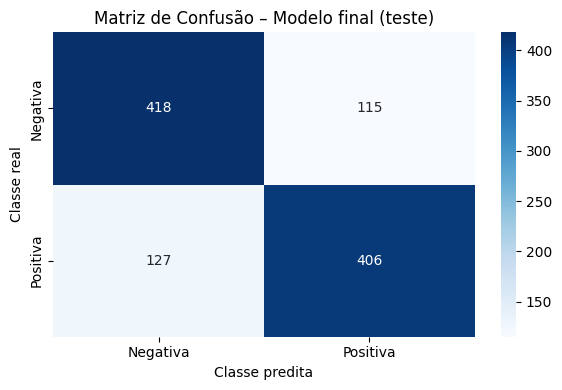


Tabela de métricas – Modelo final (teste):


,precision,recall,f1-score,support
Negativa,0.76697,0.78424,0.77551,533.00000
Positiva,0.77927,0.76173,0.77040,533.00000
Acurácia,0.77298,0.77298,0.77298,0.77298
Macro Média,0.77312,0.77298,0.77295,1066.00000


Kappa de Cohen: 0.54597
Tempo de treino do modelo final: 0.0281 s

Resumo de métricas globais – teste:


,Acurácia,Precision,Recall,F1-Score,Kappa (k),Tempo (s)
0,0.77298,0.77927,0.76173,0.7704,0.54597,0.02807


In [ ]:
# === Modelo final (com melhores parâmetros) e avaliação no teste ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, classification_report, cohen_kappa_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) Treino final com os melhores parâmetros obtidos na CV
final_model = MultinomialNB(**best_params_global)

t0 = time.time()
final_model.fit(X_trainval, y_trainval)
fit_time = time.time() - t0

# 2) Predição no teste
y_pred = final_model.predict(X_test_cv)

# 3) Matriz de confusão
labels_txt = ["Negativa", "Positiva"]
cm = confusion_matrix(y_test_cv, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_txt, yticklabels=labels_txt)
plt.title("Matriz de Confusão – Modelo final (teste)")
plt.xlabel("Classe predita"); plt.ylabel("Classe real")
plt.tight_layout(); plt.show()

# 4) Relatório de métricas 
labels_num = [0, 1]  
rep = classification_report(
    y_test_cv, y_pred,
    labels=labels_num,
    target_names=labels_txt,
    output_dict=True,
    zero_division=0
)
rep_df = pd.DataFrame(rep).T
rep_df = rep_df.loc[["Negativa","Positiva","accuracy","macro avg"]]
rep_df.index = ["Negativa","Positiva","Acurácia","Macro Média"]
print("\nTabela de métricas – Modelo final (teste):")
display(rep_df.round(3))

# 5) Kappa e tempo 
kappa = cohen_kappa_score(y_test_cv, y_pred)
print(f"Kappa de Cohen: {kappa:.3f}")
print(f"Tempo de treino do modelo final: {fit_time:.3f} s")

final_metrics = pd.DataFrame([{
    "Acurácia":  accuracy_score(y_test_cv, y_pred),
    "Precision": precision_score(y_test_cv, y_pred),
    "Recall":    recall_score(y_test_cv, y_pred),
    "F1-Score":  f1_score(y_test_cv, y_pred),
    "Kappa (k)": kappa,
    "Tempo (s)": fit_time
}]).round(3)

print("\nResumo de métricas globais – teste:")
display(final_metrics)